# CSE 252A Computer Vision I Fall 2025 - Assignment 4

Instructor: Ben Ochoa

Assigment due: Wed, Dec 3, 11:59 PM

**Name: Mehul Maheshwari**

**PID: A16478228**

## Instructions

Please answer the questions below using Python in the attached Jupyter notebook and follow the guidelines below:

- This assignment must be completed **individually**. For more details, please follow the Academic Integrity Policy and Collaboration Policy on [Canvas](https://canvas.ucsd.edu).

- All the solutions must be written in this Jupyter notebook.

- You may use basic algebra packages (e.g. `NumPy`, `SciPy`, etc) but you are not allowed to use the packages that directly solve the problems. Feel free to ask the instructor and the teaching assistants if you are unsure about the packages to use.

- It is highly recommended that you begin working on this assignment early.

- You must **submit 3 files: the Notebook, the PDF and the python file** (i.e. the `.ipynb`, the `.pdf` and the `.py` files) on Gradescope. **You must mark each problem on Gradescope in the pdf.**
    - To convert the notebook to PDF, you can choose one way below:

        - You may first export the notebook as HTML, and then print the web page as PDF

            - e.g., in Chrome: File $\rightarrow$ Save and Export Notebook as $\rightarrow$ "HTML"; or in VScode: Open the Command Palette by pressing Ctrl+Shift+P (Windows/Linux) or Cmd+Shift+P (macOS), search for Jupyter: Export to HTML
    
            - Open the saved web page and right click $\rightarrow$ Print... $\rightarrow$ Choose "Destination: Save as PDF" and click "Save")

        - If you have XeTex installed on your machine, you may directly export the notebook as PDF: e.g., in Chrome, File $\rightarrow$ Save and Export Notebook as $\rightarrow$ "PDF"

        - You may use [nbconvert](https://nbconvert.readthedocs.io/en/latest/install.html) to convert the ipynb file to pdf using the following command
        `jupyter nbconvert --allow-chromium-download --to webpdf filename.ipynb`

    - To convert the notebook to python file, you can choose one way below:

        - You may directly export the notebook as py: e.g., in Chrome, File $\rightarrow$ Save and Export Notebook as $\rightarrow$ "Executable script"; or in VScode: Open the Command Palette and search for Jupyter: Export to Python Script

        - You may use [nbconvert](https://nbconvert.readthedocs.io/en/latest/install.html) to convert the ipynb file to python file using the following command
    `jupyter nbconvert --to script filename.ipynb --output output_filename.py`

- Please make sure the content in each cell (e.g. code, output images, printed results, etc.) are clearly visible and are not cut-out or partially cropped in your final PDF file.

- While submitting on gradescope, please make sure to assign the relevant pages in your PDF submission for each problem.

**Late Policy:** Assignments submitted late will receive a 15% grade reduction for each 12 hours late (i.e., 30% per day). Assignments will not be accepted 72 hours after the due date. If you require an extension (for personal reasons only) to a due date, you must request one as far in advance as possible. Extensions requested close to or after the due date will only be granted for clear emergencies or clearly unforeseeable circumstances.

## Initial Setup

Follow the directions on https://pytorch.org/get-started/locally/ to install Pytorch on your computer.

Note: You will not need GPU support for this assignment so don't worry if you don't have one. Furthermore, installing with GPU support is often more difficult to configure so it is suggested that you install the CPU only version.

Run the torch import statements below and print the version to verify your installation.

In [2]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# Other libraries
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import pickle
from skimage import io
from array import array

print(f'Torch version {torch.__version__}')

x = torch.rand(5,3)
print("Print random tensor: \n", x)

Torch version 2.8.0
Print random tensor: 
 tensor([[0.1990, 0.0950, 0.9747],
        [0.8998, 0.8882, 0.8334],
        [0.5484, 0.0203, 0.3688],
        [0.1540, 0.6056, 0.2670],
        [0.4347, 0.3165, 0.5857]])


## Problem 1: Bayesian Classification [15 pts]

In this problem, you will segment the image given below at the pixel level as foreground or background region by applying principles from Bayesian Decision Theory. You will be provided with feature vectors obtained from known foreground and background regions, along with corresponding feature vectors computed for every pixel for the test image. Your task is to use the training features to build probabilistic models for the two classes and then classify each pixel of the test image by evaluating the posterior probabilities.

<p align="center">
  <img src="seg_image.png" alt="seg_img" width="300px"/>
</p>

**Some Context About The Training Features**  

Foreground and background regions in an image usually differ in texture. These differences can be interpreted as differences in their underlying frequency patterns. To capture this information, we use the Discrete Cosine Transform (DCT), a standard technique that represents an image block in terms of spatial patterns of varying frequencies (basis functions). If interested in learning more, see [CSE 166: Image Processing (Fall 2023)](https://cseweb.ucsd.edu/classes/fa23/cse166-a/) lecture [Basis vectors, basis images, and matrix-based transforms](https://cseweb.ucsd.edu/classes/fa23/cse166-a/lec10.pdf).

For this problem, the image (taken as grayscale) is divided into overlapping 8×8 blocks with a stride of 1, and the DCT is applied to each block. This results in 8x8, i.e., 64 DCT coefficient values. Now, from each block, we select the indices of the basis functions with the largest magnitudes (top 2 in this case), excluding the DC term that represents the average intensity. These indices will serve as the features of the local texture. All of this preprocessing has already been done for you, and you are given only the resulting feature vectors from the foreground and background regions, along with the feature vectors for every pixel in the test image.


**Tasks**

1. Read the training data from the `TrainingSamples.pickle` file for foreground and background feature vectors.

2. Compute the prior class probabilities using the training data (**3 points**).   
   $P(\text{bg}), P(\text{fg})$

3. Compute class-conditional probability distributions, and plot them (**4 points**).  

   Assume feature independence across the dimensions of the feature vector. The joint probability of the features can be now written as:  
   $P(x_1, x_2, \ldots, x_K) = \prod_{k=1}^{K} P(x_k)$   where $K$ represents the total number of features 

   For each class (foreground and background), compute a separate probability distribution for every feature value.  
   Then plot all class feature combinations PDF, i.e.:

   - $P(x_1 \mid \text{bg})$  
   - $P(x_2 \mid \text{bg})$  
   - $P(x_1 \mid \text{fg})$  
   - $P(x_2 \mid \text{fg})$

   **Note**: Each feature can take values between 1 to 64

4. Read the test image and its feature vectors corresponding to each pixel value.

5. Classify each pixel using the Maximum A Posteriori (MAP) classifier and generate the binary classification mask (0 for background and 1 for foreground) (**6 points**).  

   **Note**: The generated mask is expected to be slightly noisy.

6. Compare the predicted mask with the true mask and compute the classification error percentage (**2 points**).  

### Part 1.1: Read the Training Data and Compute Class Prior Probabilities [3 pts]

In [3]:
## Load training data

file_train_data = open('TrainingSamples.pkl', 'rb')
train_data = pickle.load(file_train_data)
file_train_data.close()
bg_train_data = train_data['background']
fg_train_data = train_data['foreground']

In [4]:
def compute_class_priors(bg_data, fg_data):
    """Compute class prior probabilities for background and foreground classes.
    
    Args:
        bg_data: NxD array of background training data, N is the number of samples, D is number of the feature dimensions.
        fg_data: MXD array of Foreground training data, M is the number of samples, D is number of the feature dimensions.

    Returns:
        p_prior_bg: Prior probability of the background class.
        prior_fg: Prior probability of the foreground class.
    """

    """ ==========
    YOUR CODE HERE
    ========== """

    p_prior_bg = bg_data.shape[0] / (bg_data.shape[0] + fg_data.shape[0])
    p_prior_fg = fg_data.shape[0] / (bg_data.shape[0] + fg_data.shape[0])


    return p_prior_bg, p_prior_fg


p_prior_bg, p_prior_fg = compute_class_priors(bg_train_data, fg_train_data)
print(f"Prior Probability of Background Class: {p_prior_bg}")
print(f"Prior Probability of Foreground Class: {p_prior_fg}")

Prior Probability of Background Class: 0.725359181880921
Prior Probability of Foreground Class: 0.274640818119079


### Part 1.2: Compute Class Conditional Probability Distributions [4 pts]

You may use the `plot_feature_pdf` function to plot the probability distributions for every feature dimension.

In [5]:
# DO NOT MODIFY THIS CODE
def plot_feature_pdf(p_bg_feature, p_fg_feature, feature_number):
    """
    Plots the class-conditional probability distribution for a single feature for both classes.

    Args:
        p_bg_feature    : 1D array, P(x_k | bg) for this feature
        p_fg_feature    : 1D array, P(x_k | fg) for this feature
        feature_number  : integer, index of the feature being plotted starting from 1
    """
    assert len(p_bg_feature) == len(p_fg_feature)

    x_values = np.arange(1, len(p_fg_feature) + 1)
    plt.figure(figsize=(8, 4))
    plt.plot(x_values, p_bg_feature, label="P(x_{} | bg)".format(feature_number))
    plt.plot(x_values, p_fg_feature, label="P(x_{} | fg)".format(feature_number))

    plt.title(f"Class Conditional PDFs for Feature {feature_number}")
    plt.xlabel("Feature value")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

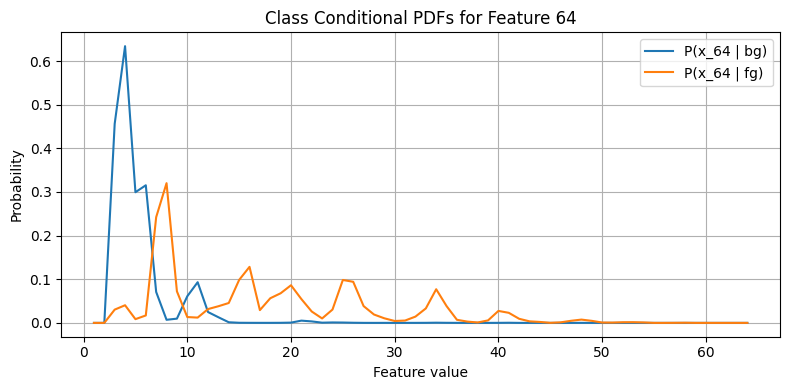

In [8]:
def compute_feature_class_conditional_pdf(bg_feature_data, fg_feature_data):
    """
    Computes the class-conditional probability distributions for a single feature.

    Parameters:
        bg_feature_data   : 1D background feature array of size N
        fg_feature_data   : 1D background feature array of size M

    Returns:
        p_bg_feature  : P(x_k | bg), 1D array of size 64 
        p_fg_feature  : P(x_k | fg), 1D array of size 64
    """

    """ ==========
    YOUR CODE HERE
    ========== """

    p_bg_feature = np.zeros(64)
    p_fg_feature = np.zeros(64)

    for i in range(64):
        p_bg_feature[i] = np.sum(bg_feature_data == i) / len(bg_feature_data)
        p_fg_feature[i] = np.sum(fg_feature_data == i) / len(fg_feature_data)


    return p_bg_feature, p_fg_feature

""" ==========
YOUR CODE HERE TO COMPUTE AND PLOT THE CLASS-CONDITIONAL PDFS
========== """

#plot the class-conditional pdfs
# bg_train_data
# fg_train_data
# p_prior_bg
# p_prior_fg

p_bg_feature, p_fg_feature = compute_feature_class_conditional_pdf(bg_train_data, fg_train_data)
feature_number = 64
plot_feature_pdf(p_bg_feature, p_fg_feature, feature_number)


### Part 1.3: Classify using Maximum A Posteriori (MAP) Classifier [6 pts]

Test data shape: (512, 512, 2)


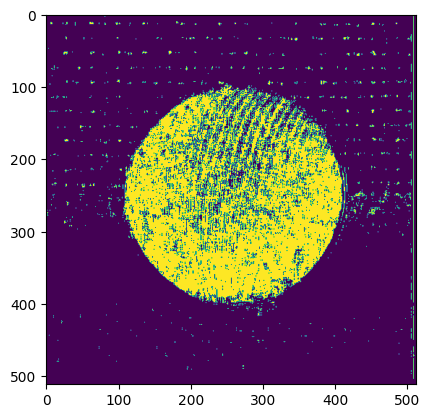

In [10]:
# Read the test data
file_test_data = open('TestImageFeatures.pkl', 'rb')
test_data = pickle.load(file_test_data)
file_test_data.close()
test_features = test_data['features']
print(f"Test data shape: {test_features.shape}")

def classify_map(test_features, p_bg_features, p_fg_features, prior_bg, prior_fg):
    """
    Classify test samples using Maximum A Posteriori (MAP) rule.

    Args:
        test_features : M x N x D array of test features where M X N refers to image size and D refers to number of features
        p_bg_features : D x 64 array containing background class conditional probability for features
        p_fg_features : D x 64 array containing foreground class conditional probability for features
        p_prior_bg    : Prior probability of background class
        p_prior_fg    : Prior probability of foreground class
    Returns:
        prediction_mask   : M X N mask with value 0 for background and 1 for foreground
    """
    """ ==========
    YOUR CODE HERE
    ========== """
    M, N, D = test_features.shape
    prediction_mask = np.zeros((M, N), dtype=np.uint8)

    # MAP = max(P(bg) * P(x1 | bg) * P(x2 | bg) * ... * P(x64 | bg), P(fg) * P(x1 | fg) * P(x2 | fg) * ... * P(x64 | fg))

    for i in range(M):
        for j in range(N):
            bg_posterior = p_prior_bg * np.prod(p_bg_features[test_features[i, j, :]])
            fg_posterior = p_prior_fg * np.prod(p_fg_features[test_features[i, j, :]])
            prediction_mask[i, j] = 1 if fg_posterior > bg_posterior else 0


    return prediction_mask

""" ==========
YOUR CODE HERE TO COMPUTE AND DISPLAY THE PREDICTED MASK USING MAP CLASSIFIER
========== """
prediction_mask = classify_map(test_features, p_bg_feature, p_fg_feature, p_prior_bg, p_prior_fg)
# visualize the predicted mask
plt.imshow(prediction_mask)
plt.show()


### Part 1.4: Compute the percentage error of classification [2 pts]

In [14]:
# Read the binary ground truth mask
ground_truth_mask = io.imread('seg_mask.png', as_gray=True)
binary_mask = (ground_truth_mask > 128).astype(np.uint8)
""" ==========
YOUR CODE HERE TO COMPUTE AND PRINT CLASSIFICATION ERROR PERCENTAGE
========== """
M, N = prediction_mask.shape
error_mask = np.abs(prediction_mask - binary_mask)
print(np.sum(error_mask))
print(M * N)
error_percentage = np.sum(error_mask) / (M * N)
print(f"Classification Error Percentage: {error_percentage * 100}%")


4409885
262144
Classification Error Percentage: 1682.2376251220703%


## Problem 2: Machine Learning [30 pts]
In this problem, you will implement several machine learning solutions for computer vision problems.

### Part 2.1: Download MNIST data [3 pts]

We will be using the Modified National Institute of Standards and Technology (MNIST) database for this problem. It is a well-known dataset consisting of 28x28 grayscale images of handwritten digits. The database consists of 60,000 train samples, and 10,000 test samples.

To download it, visit the "Resources" tab on our Piazza page.

We will be using the following four files:

1. train-images.idx3-ubyte.gz: training set images
2. train-labels.idx1-ubyte.gz: training set labels
3. t10k-images.idx3-ubyte.gz: test set images
4. t10k-labels.idx1-ubyte.gz: test set labels


Download the files, and change the variable 'path' in the code below.
Plot one random example image corresponding to each label from training data.

In [ ]:
# Change path as required
path = "mnist/"

def read(dataset = "training", datatype='images'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)

In [ ]:
#Load the data

#Train set
trainData = np.array(list(read('training','images'))).astype(np.float32)
trainLabels = np.array(list(read('training','labels')))

#Test set
testData = np.array(list(read('testing','images'))).astype(np.float32)
testLabels=np.array(list(read('testing','labels')))

# Understand the shapes
print(trainData.shape, trainLabels.shape)
print(testData.shape, testLabels.shape)

Complete the `plot_sample_images()` to plot a 1x10 figure, where each column displays a sample image from a class. The following image gives an example:
<!--- ![mnist](fig/mnist_example_plot.png) --->
<!--- The previous results in export to pdf errors on some systems but the following does not --->
<img src="fig/mnist_example_plot.png">

In [ ]:
def plot_sample_images(trainX, trainY):
    """
    Function to plot a sample image for each category,
    The result is a figure with 1x10 grid of images.
    """
    plt.figure(figsize=(20, 10))
    """ ==========
    YOUR CODE HERE
    ========== """

    plt.show()

In [ ]:
# Plot the sample images as a 1x10 figure
plot_sample_images(trainData, trainLabels)

### Problem 2.2: Recognizing hand-written digits with a KNN Classifier using sklearn [5 pts]

In this part
* complete the RandomClassifier class - given an input image, output a random class
* complete the kNNClassifier class

The Sklearn library provides an easy way to build and call different models. We will use `sklearn.neighbors.KNeighborsClassifier`. Check out the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [ ]:
# DO NOT CHANGE
# #Reshape the 2D Image matrix to 1D vector: (28, 28) -> (784,)
#Shape of train_data: (N_train, 28, 28) -> (N_train, 784)
trainData = trainData.reshape(trainData.shape[0], -1)

#Shape of test_data: (N_test, 28, 28) -> (N_test, 784)
testData = testData.reshape(testData.shape[0], -1)

print("-----------------\n")
print("After reshaping the data")
print(trainData.shape, trainLabels.shape)
print(testData.shape, testLabels.shape)

In [ ]:
# DO NOT CHANGE
#### Some helper functions are given below####

def DataBatch(data, label, batchsize, shuffle=True):
    """
    a generator for batches of data
    yields data (batchsize, 28, 28) and labels (batchsize)
    if shuffle is True, it will load batches in a random order
    """

    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

def test(testData, testLabels, classifier):
    # tests the accuracy of a classifier
    batchsize=40
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize,shuffle=False):
        prediction = classifier(data)
        correct += np.sum(prediction==label)
    return correct/testData.shape[0]*100

In [ ]:
#Random Classifier
class RandomClassifier():
    """
    A random classifier.
    Given an input image, it outputs a random class
    """
    def __init__(self, classes=10):
        self.classes=classes

    def __call__(self, x):
        """ ==========
        YOUR CODE HERE
        ========== """
        


In [ ]:
# TEST CODE: DO NOT CHANGE
randomClassifierX = RandomClassifier()
print ('Random classifier accuracy: %f'%test(testData, testLabels, randomClassifierX))

In [ ]:
#Sklearn KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

class kNNClassifier():
    def __init__(self, k=5, algorithm='brute'):
        """
        Initialize KNN model.

        Inputs:
        k: number of neighbors involved in voting
        algorithm: Algorithm used to compute nearest neighbors
        """
        """ ==========
        YOUR CODE HERE
        ========== """
        

    def train(self, trainData, trainLabels):
        """
        Train your model with image data and corresponding labels.

        Inputs:
        trainData: Training images (N_train,784)
        trainLabels: Labels (N_train,)
        """
        """ ==========
        YOUR CODE HERE
        ========== """


    def __call__(self, x):
        """
        Predict the trained model on test data.

        Inputs:
        x: Test images (N_test, 784)

        Returns:
        predicted labels (N_test,)
        """
        """ ==========
        YOUR CODE HERE
        ========== """
        

In [ ]:
# Initialize the KNN classifier and train the model
# Print the accuracy of the knn classifier (sklearn)
""" ==========
YOUR CODE HERE
========== """


### Problem 2.3: Confusion Matrix [5 pts]

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

Here you will implement a function that computes the confusion matrix for a classifier. The matrix (M) is $n \times n$ where $n$ is the number of classes. Entry `M[i,j]` represents the counts of images from class `i` that was classified as class `j`.

Your task is to:
* complete the `Confusion()`
* plot the results for `randomClassifier` and discuss the results
* plot the results for `kNNClassifier`

The following image shows a visual example of a confusion matrix:
<p>
    <img src="fig/eg_confusion.png" width="300px"/>
</p>

In [ ]:
from tqdm import tqdm

def Confusion(testData, testLabels, classifier):
    '''
    Compute the confusion matrix and accuracy for the classifier.
    Inputs:
        testData: Test images (N_test, 784)
        testLabels: Test labels (N_test,)
        classifier: The model to predict the labels
    Returns:
        M: The confusion matrix
        acc: The accuracy of the model
    '''
    batchsize = 40
    M = np.zeros((10,10))
    acc = 0

    for data,label in tqdm(DataBatch(testData,testLabels,batchsize,shuffle=False),total=len(testData)//batchsize):
        """ ==========
        YOUR CODE HERE
        ========== """

def VisualizeConfusion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)
    plt.show()
    print(np.round(M,2))

In [ ]:
# Print the accuracy and plot the confusion matrix for the random classifier on the test set
M_r, acc_r = Confusion(testData, testLabels, randomClassifierX)
print(f"Accuracy of random classifier {acc_r*100}%")

VisualizeConfusion(M_r)

#### **Exercise**: Justify the accuracy & values of the confusion matrix of the random classifier below.


Your answer:

In [ ]:
# Print the accuracy and plot the confusion matrix for the KNN classifier on the test set
""" ==========
YOUR CODE HERE
========== """


### Problem 2.4: K-Nearest Neighbors (KNN) [8 pts]

For this problem, you will complete a simple kNN classifer ***without Sklearn***. The distance metric is ***Euclidean distance (L2 norm)*** in pixel space. You may use the **np.linalg.norm** function to compute distance. $k$ refers to the number of neighbors involved in voting on the class. Use $k$ value to be equal to 3.

**NOTE:** 
* For debugging the code, use only the first 250 train samples. You can expect to get 74.02% accuracy while using the first 250 training samples.
* For the final submission, you are encouraged to use the entire training set (60000 samples). However, it may take some time (~ 30 mins). If you get the expected accuracy for 250 train samples, this should just be a 1 time run.
* In case it takes too long, you may consider the first 30000 training samples.
* Do not reduce the size of the test set

In [ ]:
class kNNClassifierManual():
    def __init__(self, k=3):
        self.k = k

    def train(self, trainData, trainLabels):
        self.X_train = trainData
        self.y_train = trainLabels

    def __call__(self, X):
        """
        Predict the labels for the input data using KNN method.

        Inputs:
        X: Test images (N_test,784)

        Returns:
        predicted labels (N_test,)
        """
        """ ==========
        YOUR CODE HERE
        ========== """
        
# test your classifier with only the first 250 training examples 
# (use this while debugging)
# note you must get 74.02% accuracy
knnClassiferX = kNNClassifierManual()
knnClassiferX.train(trainData[:250], trainLabels[:250])
print(f'KNN classifier accuracy: {test(testData, testLabels, knnClassiferX)}%')

In [ ]:
# Initialize the KNN classifier and assign the train data
# Print the accuracy and plot the confusion matrix for the knn classifier (manual) on the test set
# (This may take a max of 30 min)
""" ==========
YOUR CODE HERE
========== """


In [ ]:
# In case it takes too long to run the previous cell, you can use the following code. 
# You DO NOT HAVE TO RUN THIS CELL if the previous cell runs successfully.
# Initialize the KNN classifier and assign the train data
# Print the accuracy and plot the confusion matrix for the knn classifier (manual) on the test set
# Using the first 30000 training examples
""" ==========
YOUR CODE HERE
========== """


#### **Exercise**: What number, other than itself, is the number '2' predicted to be? Also calculate the percentage of error for predicting the number 2.

Your answer:

### Problem 2.5: Principal Component Analysis (PCA) K-Nearest Neighbors (KNN) [9 pts]
Here you will implement a simple KNN classifer in PCA space (for k=5 and 30 principal components).
You must implement PCA yourself using singular value decomposition (SVD) **(you may not use sklearn.decomposition.PCA or any other package that directly implements PCA transformations)**

You may use your previous implementation of the KNN classifier in this part or you may use `KNeighborsClassifier` from sklearn.

In [ ]:
class PCAKNNClassifer():
    def __init__(self, components=30, k=5):
        """
        Initialize PCA kNN classifier

        Inputs:
        components: number of principal components
        k: number of neighbors involved in voting
        """
        """ ==========
        YOUR CODE HERE
        ========== """

    def train(self, trainData, trainLabels):
        """
        Train your model with image data and corresponding labels.

        Inputs:
        trainData: Training images (N_train, 784)
        trainLabels: Labels (N_train,)
        """
        """ ==========
        YOUR CODE HERE
        ========== """

    def __call__(self, x):
        """
        Predict the trained model on test data.

        Inputs:
        x: Test images (N_test, 784)

        Returns:
        predicted labels (N_test,)
        """
        """ ==========
        YOUR CODE HERE
        ========== """

# test your classifier with only the first 250 training examples
# (use this while debugging)
# note you must get 75.8% accuracy
pcaknnClassiferX = PCAKNNClassifer()
pcaknnClassiferX.train(trainData[:250], trainLabels[:250])
print ('PCA KNN classifier accuracy: %f'%test(testData, testLabels, pcaknnClassiferX))

In [ ]:
# Initialize the PCA KNN classifier and assign the training data
# Print the accuracy and plot the confusion matrix for the PCA KNN classifier on the test set
""" ==========
YOUR CODE HERE
========== """

#### Exercise:  Is the testing time for PCA KNN classifier more or less than that for KNN classifier? Comment on why it differs, if it does.


Your answer:

## Problem 3: Deep learning [28 pts]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.optim as optim

from scipy.stats import truncnorm
from tqdm import tqdm

### Problem 3.1:  Training with PyTorch [8 pts]

Below is some helper code to train your deep networks.

Complete the `train_net()` for DNN below. You must code the training operations in this function.
For a batch of data you have to
* initialize the gradients
* forward propagate the data
* compute error
* do back propagation
* finally update the parameters.

**NOTE:**
* You would have to choose an appropriate ***loss function*** and ***optimizer*** from PyTorch for this problem.
* Set the default learning rate as 3e-4, epoch as 15 and batch size as 40
* Append ***each batch*** loss in the list `self.losses`. The size of self.losses after training must be `epochs*number_batches`. This will be used in the later section.

This function will be used in the following questions with different networks.
You may look at [this toturial](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

In [ ]:
# Base class for your deep neural networks

class DNN(nn.Module):
    def __init__(self, lr = 3e-4):
        super(DNN, self).__init__()
        self.lr = lr
        self.losses = []

    def forward(self, x):
        raise NotImplementedError # You do not need need to implement anything here

    def train_net(self, X_train, y_train, epochs=15, batchSize=40):
        """ ==========
        YOUR CODE HERE
        ========== """
        

    def __call__(self, x):
        self.eval()  # set network in evaluation mode
        inputs = torch.tensor(x, dtype=torch.float32)
        prediction = self.forward(inputs)
        return np.argmax(prediction.data.cpu().numpy(), 1)

    def plot_losses(self):
        plt.plot(self.losses)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Training loss over {len(self.losses)} iterations with learning rate {self.lr}')
        plt.show()

# Helper function to intialize weight variables
def weight_variable(shape):
    initial = torch.Tensor(truncnorm.rvs(-1/0.01, 1/0.01, scale=0.01, size=shape))
    return nn.Parameter(initial, requires_grad=True)

# helper function to get bias variables
def bias_variable(shape):
    initial = torch.Tensor(np.ones(shape)*0.1)
    return nn.Parameter(initial, requires_grad=True)

In [ ]:
# Example linear classifier - input connected to output
# You can use this as an example to see how to extend the DNN class

class LinearClassifier(DNN):
    def __init__(self, lr = 3e-4, in_features=28*28, classes=10):
        super(LinearClassifier, self).__init__(lr)
        # in_features=28*28
        self.weight1 = weight_variable((classes, in_features))
        self.bias1 = bias_variable((classes))

    def forward(self, x):
        # linear operation
        y_pred = torch.addmm(self.bias1, x.view(list(x.size())[0], -1), self.weight1.t())
        return y_pred

In [ ]:
# Re-loading the train data
trainData = np.array(list(read('training','images')))
trainLabels = np.int32(np.array(list(read('training','labels'))))

# Add a channel dimension to the data - Since these are grayscale images, the channel dimension is 1
# Normalize
# Reshape the data to (N, C, H, W) format
trainData = np.float32(np.expand_dims(trainData, -1))/255
trainData = trainData.transpose((0,3,1,2))

# Re-loading the train data
testData = np.array(list(read('testing','images')))
testLabels = np.int32(np.array(list(read('testing','labels'))))

# Add a channel dimension to the data - Since these are grayscale images, the channel dimension is 1
# Normalize
# Reshape the data to (N, C, H, W) format
testData=np.float32(np.expand_dims(testData,-1))/255
testData=testData.transpose((0,3,1,2))


print("-----------------\n")
print("After reshaping the data")
print(trainData.shape, trainLabels.shape)
print(testData.shape, testLabels.shape)


In [ ]:
# Initialize the Linear classifier and train the model
# Print the accuracy and plot the confusion matrix for the linear classifier on the test set
# Note - You must get ~92% accuracy for 15 epochs and batch size 40
""" ==========
YOUR CODE HERE
========== """

### Problem 3.2: Single Layer Perceptron [3 pts]

The simple linear classifier implemented in the cell already performs quite well. Plot the ***weights*** of the fully connected layer corresponding to each output class as images ***(not the biases)***. (Plot a 1x10 figure, where each column corresponds to the filter weights of a class, just like as you did in Problem 2.1)

Comment on what the weights look like, and why you think this is the result.

**NOTE:** To obtain the weights, you can access the ***linear layer*** in the model. For example you can obtain the weights in `weight1` by accessing `weight1.data`. ***Normalize*** and ***reshape*** the weights to make sense of them. You may explore different ***cmaps*** like ***plasma***, ***inferno***, etc

In [ ]:
# Plot filter weights corresponding to each class.
# Plot a 1x10 figure where each column corresponds to the filter weights of a class
# Normalize the weights to be between 0 and 1
# Reshape the weights
""" ==========
YOUR CODE HERE
========== """

#### Exercise: Comment on what the weights look like and your reasoning.

Your answer:

### Part 3.3: Multi Layer Perceptron (MLP) [5 pts]
Here you will implement an MLP. The MLP must consist of 2 layers (matrix multiplication and bias offset) that map to the following feature dimensions:

* Hidden layer: 150 dimensional feature
* Output layer: 10 dimensional feature (10 classes)

* The hidden layer must be followed with a ReLU nonlinearity. The output layer must not have a nonlinearity applied as we desire the raw logits output. You may use `F.relu` for this.

Display the confusion matrix and accuracy after training. Note: You must get ~97 % accuracy for 15 epochs and batch size 40.

Plot the filter weights of
* layer 1 corresponding to the mapping from the inputs to the first 10 hidden layer outputs (out of 150).
* layer 2

Do the weights look similar to the weights plotted in the previous problem? Why or why not?

**Note**: You MUST initialize the weights with the helper functions given above, and then perform the described operations in `forward()`. You are NOT allowed to simply just use `nn.Linear` for example in this assignment. While in practice you would simply use these modules, we want you to implement the operations that they perform.

It is expected that the training model would take a few minutes to run.

In [ ]:
class MLPClassifer(DNN):
    def __init__(self, in_features=28*28, classes=10, hidden=100):
        """
        Initialize weight and bias variables
        """
        super(MLPClassifer, self).__init__()
        """ ==========
        YOUR CODE HERE
        ========== """

    def forward(self, x):
        """ ==========
        YOUR CODE HERE
        ========== """

In [ ]:
# Initialize the MLP classifier and train the model
# Print the accuracy and plot the confusion matrix for the MLP classifier on the test set
# Note - You must get ~97 % accuracy for 15 epochs and batch size 40.
""" ==========
YOUR CODE HERE
========== """

#### Plot the resulting layer 1 filter weights (1x10 figure)

In [ ]:
# Plot the resulting layer 1 filter weights as a 1x10 figure
# You may reuse the earlier code
""" ==========
YOUR CODE HERE
========== """

#### Plot the resulting layer 2 filter weights (1x10 figure)

In [ ]:
# Plot the resulting layer 2 filter weights as a 1x10 figure
# You may reuse the earlier code
""" ==========
YOUR CODE HERE
========== """

#### Exercise: Do the weights look similar to the weights plotted in the previous problem? Why or why not?


Your answer:

### Problem 3.4: Convolutional Neural Network (CNN) [8 pts]

Here you will implement a CNN with the following architecture:

* Convolutional layer with 5x5 kernels, stride of 2, padding of 2, and 10 output channels, with bias
* Convolutional layer with 5x5 kernels, stride of 2, padding of 2, and 15 output channels, with bias
* Linear layer with 32 hidden units, with bias
* Linear layer with 10 hidden units (number of classes), with bias
* ReLU activation after each, except for the output layer.

So, 2 convolutional layers, followed by 1 fully connected hidden layer into the output layer.

**Note**: You MUST initialize the weights with the helper functions given above, and then perform the described operations in the `forward()` function. You are **NOT allowed** to simply just use `nn.Linear`, `nn.Conv2d` or `nn.Sequential` for example in this assignment. While in practice you could simply use these modules, we want you to implement the operations that they perform. You may use `F.conv2d`, `F.relu` and `torch.addmm` functions.

Display the confusion matrix and accuracy after training. You must get ~98% accuracy for 15 epochs and batch size 40.

In [ ]:
# Helper function to perform convolution
def conv2d(x, W, stride, padding, bias):
    # x: input
    # W: weights (out, in, kH, kW)
    # stride: stride
    # padding: padding
    # bias: bias (out)
    return F.conv2d(x, W, stride=stride, padding=padding, bias=bias)

# Convolutional Neural Network
class CNNClassifer(DNN):
    def __init__(self, input_features=28*28, classes=10):
        super(CNNClassifer, self).__init__()
        """ ==========
        YOUR CODE HERE
        ========== """

    def forward(self, x):
        """ ==========
        YOUR CODE HERE
        ========== """

In [ ]:
# Initialize the CNN Classifier and train the model
# Print the accuracy and plot the confusion matrix for the test data
# Note - You must get ~98% accuracy for 15 epochs and batch size 40.

""" ==========
YOUR CODE HERE
========== """

* Note that the MLP/ConvNet approaches lead to an accuracy a little higher than the K-NN approach.
* In general, Neural net approaches lead to significant increase in accuracy, but in this case since the problem is not too hard, the increase in accuracy is not very high.
* However, this is still quite significant considering the fact that the ConvNets we've used are relatively simple while the accuracy achieved using K-NN is with a search over 60,000 training images for every test image.
* You can look at the performance of various machine learning methods on this problem at https://yann.lecun.org/exdb/mnist/
* PyTorch has a bunch of great tutorials online. You can learn more about neural networks and pytorch through the tutorials on their site for example: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
* You can play with a demo of neural network created by Daniel Smilkov and Shan Carter at https://playground.tensorflow.org/

### Part 3.5: Hyperparameter Experiment (4 pts)

Hyperparameters are parameters which are used to control the training/optimization process. These hyperparameters, unlike the parameters within the model, are set usually at the beginning of training and are not learned through the optimization process.

Learning rate is an example of a hyperparameter. You may re-use the `LinearClassifier()` class we defined in Problem 2.1. Train the model with the following settings for learning rate and call the `plot_losses()` function to show the loss over the iterations.

Train for just 5 epochs with three different settings of learning rate:

* Learning rate = 0.2
* Learning rate = 0.002
* Learning rate = 0.00002

Comment below on the results of the experiment. What do you see?

In [ ]:
# Train and plot with learning rate = 0.2

In [ ]:
# Train and plot with learning rate = 0.002

In [ ]:
# Train and plot with learning rate = 0.00002

#### Exercise: Comment below on the results of the experiment. What do you see? (comment on the convergence speed, whether the steps are noisy, is the training complete?)

Your answer: